Learn iterator for multiphase elastic problems using SAC-FEANet

In [1]:
import pacnet.pac as pac

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.nn.modules.utils import _pair
import os
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import time
from functools import reduce

from utils import plot
from feanet.model import PACFEANet
from feanet.jacobi import JacobiBlock
from data.dataset import ThermalDataSet

In [2]:
device_predict = torch.device('cpu') #torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
class SingleGrid():
    '''
    Perform weighted Jacobi iteration relaxation for a single grid.
    '''
    def __init__(self, size, n_elem, mode, dev):
        self.size = size # actual size of the plate
        self.mode = mode
        self.device = dev
        self.n_elem = n_elem
        self.h = size/n_elem
        self.net = self.InstantiateNetwork()
        self.jac = JacobiBlock(self.net, self.h, self.device, self.mode)

    def IsCoarsest(self):
        return self.n_elem == 2
        
    def InstantiateNetwork(self):
        model = PACFEANet(self.device, self.mode).double()
        model.requires_grad_(False)
        return model.to(self.device)

Test SAC-FEANet for elastic problems

In [4]:
model_name = 'thermal_type1_2d_33x33'
training_set = ThermalDataSet('data/thermal/thermal2d_33x33.h5', device)
model_dir = 'model/learn_iterator/thermal_type1'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

bs = 16
train_dataloader = DataLoader(training_set, batch_size=bs, shuffle=True)
dirich_idx_train, dirich_value_train, neumann_idx_train, neumann_value_train, material_train, f_train, u_train = next(iter(train_dataloader))
k = 0 # the index of training data to be shown

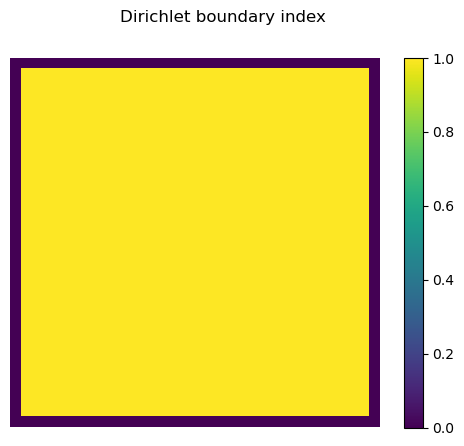

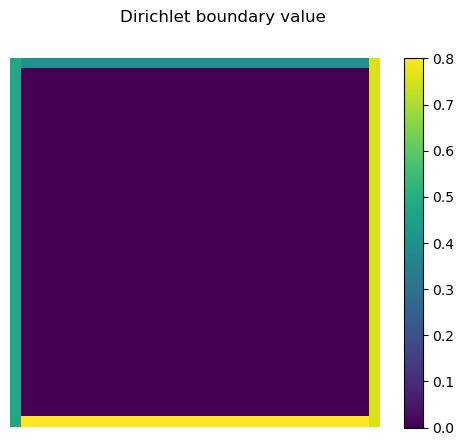

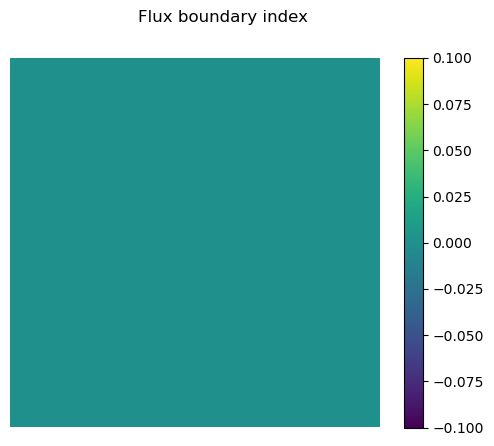

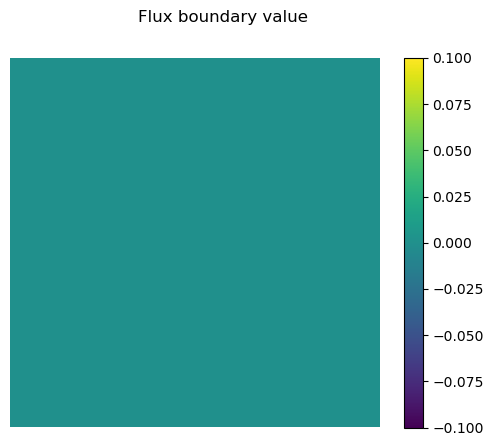

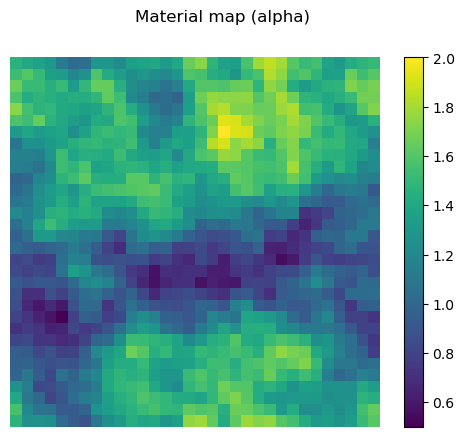

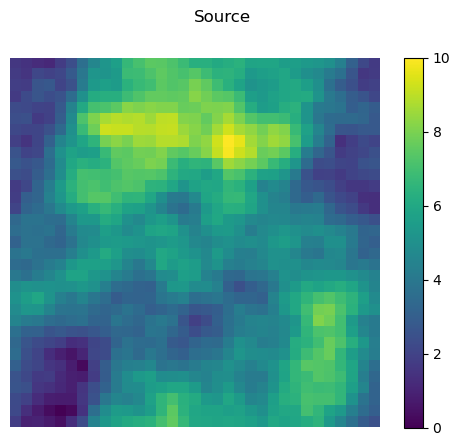

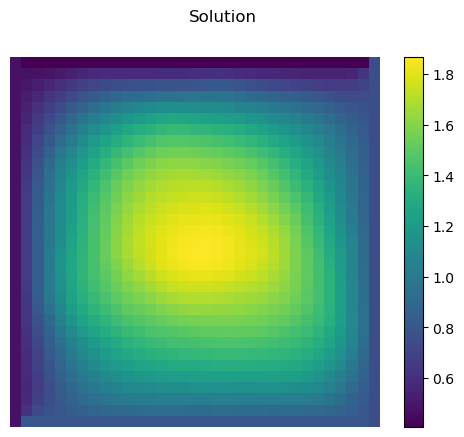

In [5]:
plot.plot_thermalfield(dirich_idx_train[k], ftitle='Dirichlet boundary index')
plot.plot_thermalfield(dirich_value_train[k], ftitle='Dirichlet boundary value')
plot.plot_thermalfield(neumann_idx_train[k], ftitle='Flux boundary index')
plot.plot_thermalfield(neumann_value_train[k], ftitle='Flux boundary value')
plot.plot_thermalfield(material_train[k], ftitle='Material map (alpha)')
plot.plot_thermalfield(f_train[k], ftitle='Source')
plot.plot_thermalfield(u_train[k], ftitle='Solution')

In [20]:
domain_size = 2
n_elem = 2**5
ku, kf = 1, 1
h = domain_size/n_elem
grid = SingleGrid(domain_size, n_elem=n_elem, mode='thermal', dev=device_predict)

In [21]:
EPS = 1e-6
n_jac = 0
u_test = torch.ones(size=(1, ku, n_elem+1, n_elem+1), requires_grad=False, dtype=torch.double).to(device_predict)
solution_test, f_test, d_test, d_idx_test, t_test, t_idx_test, m_test = (torch.unsqueeze(u_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(f_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_value_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_idx_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_value_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_idx_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(material_train[k], 0).to(device_predict))


0 6.21109784110908
1 3.4228590730159576
2 2.437962617027888
3 1.9173546953824832
4 1.590055211719954
5 1.3631581961095884
6 1.1957125434660083
7 1.0666722952033665
8 0.9640246113685466
9 0.8803685536933351
10 0.8108727565656064
11 0.7522372981505319
12 0.7021249995899959
13 0.6588305683360438
14 0.6210784128764881
15 0.5878939560157205
16 0.5585188883191724
17 0.5323537201575852
18 0.5089178564140063
19 0.487821237878826
20 0.4687438051492703
21 0.45142036672796165
22 0.43562927218458236
23 0.4211838108189229
24 0.40792559345345125
25 0.39571939826417646
26 0.3844491120824115
27 0.3740145017259842
28 0.3643286216224263
29 0.3553157145311032
30 0.34690949826301676
31 0.33905175738673216
32 0.3316911779911447
33 0.3247823776907796
34 0.3182850936134535
35 0.3121634990834763
36 0.3063856257965128
37 0.3009228729660468
38 0.29574958855914096
39 0.2908427105873464
40 0.28618145866516786
41 0.2817470678326694
42 0.2775225580647024
43 0.2734925340354484
44 0.2696430106331896
45 0.265961260472

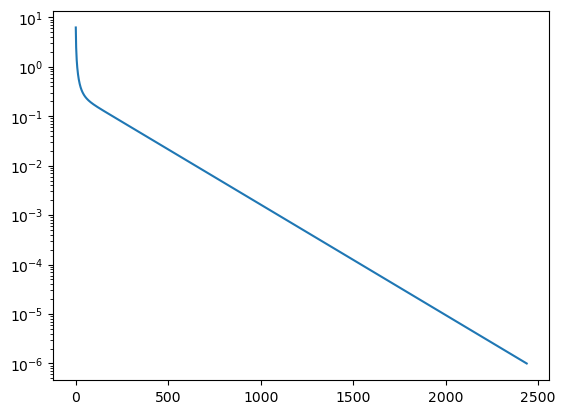

In [22]:
u_test = grid.jac.reset_boundary(u_test, d_test, d_idx_test)
residual = grid.net(h, u_test, f_test, t_test, t_idx_test, m_test)
res = torch.norm(residual[:, :, 1:-1, 1:-1]).item() 
res_arr = [res]
print(n_jac, res)
while (abs(res) > EPS):
    u_test = grid.jac.jacobi_convolution(h, u_test, f_test, t_test, t_idx_test, d_test, d_idx_test, m_test)
    residual = grid.net(h, u_test, f_test, t_test, t_idx_test, m_test)
    res = torch.norm(residual[:, :, 1:-1, 1:-1]).item() 
    res_arr.append(res)
    n_jac += 1
    print(n_jac, res)

print("Solution converges after", n_jac, "Jacobi iterations ")
plt.plot(res_arr)
plt.yscale('log')


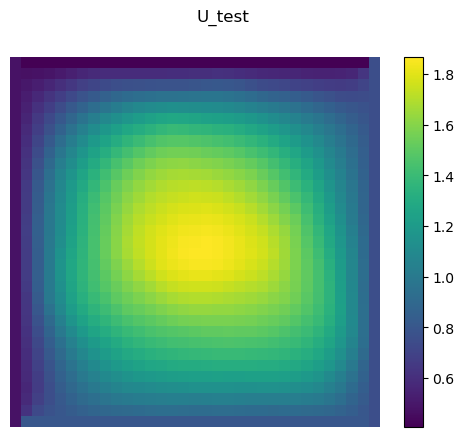

In [9]:
plot.plot_thermalfield(u_test[0], "U_test")

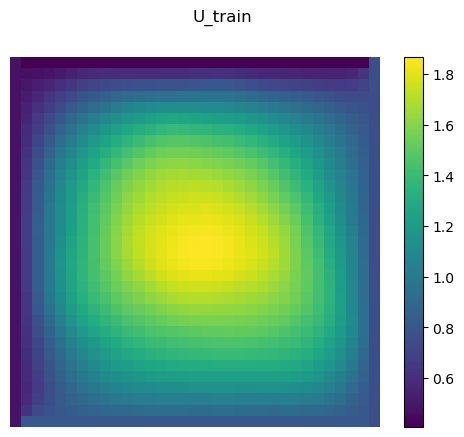

In [10]:
plot.plot_thermalfield(solution_test[0], "U_train")

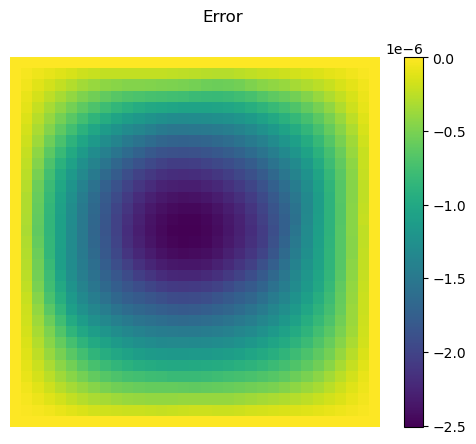

In [11]:
plot.plot_thermalfield(u_test[0]-solution_test[0], 'Error')

In [12]:
class PsiNet(nn.Module):
    def __init__(self, nb_layers=3, mode='thermal'):
        super(PsiNet, self).__init__()

        self.mode = mode
        self.km, self.ku, self.kf = 1, 1, 1 # thermal problem
        if(self.mode == 'elastic'):
            self.km, self.ku, self.kf = 2, 2, 2
            
        '''
        self.attention_map = nn.Sequential(
            nn.Conv2d(self.km, 1, kernel_size=2, padding=1),
            nn.Conv2d(1, 1, kernel_size=5, padding=2),
            nn.Conv2d(1, self.ku, kernel_size=1, padding=0),
            nn.BatchNorm2d(num_features=self.ku),
            nn.Unfold(kernel_size=3, padding=1),
            nn.Sigmoid()
            )
        '''
        self.smoother = nn.ModuleList([nn.Conv2d(self.ku, self.ku, 3, padding=1, bias=False)
                                         for _ in range(nb_layers)])

    def forward(self, m, x, dirich_idx):
        '''
        m: material field
        x: error between Jacobi solution and initial guess '''
        
        #bs0, ku0, h0, w0 = x.size()
        #new_x = F.unfold(x, kernel_size = 3, padding = 1).view(bs0, ku0, -1, h0, w0) # shape (bs, ku, 9, h, w)
        #attention = self.attention_map(m).view(bs0, ku0, -1, h0, w0) # shape (bs, ku, 9, h, w)
        #attention_x = new_x * attention # shape (bs, ku, 9, h, w)
        #attention_x = attention_x.sum(dim=2) # shape (bs, ku, h, w)
        return reduce(lambda acc, el: el(acc) * dirich_idx, self.smoother, x) # shape (bs, ku, h, w)

In [13]:
class PsiIterator(nn.Module):
    def __init__(self, 
                 dev,
                 size=2, 
                 psi_net=None,
                 grid=None,
                 n=2**5,
                 batch_size=8,
                 max_epochs=1000,
                 mode='thermal',
                 model_dir=model_dir):
        super(PsiIterator, self).__init__()
        self.size = size
        self.device = dev
        self.n = n
        self.h = size/n
        self.mode = mode
        self.batch_size = batch_size
        self.max_epochs = max_epochs
        self.loss = nn.MSELoss(reduction='sum')
        
        if(grid is None):
            self.grid = SingleGrid(size, n, mode=mode, dev=self.device)
        else:
            self.grid = grid

        if(psi_net is None):
            self.psi_net = PsiNet(nb_layers=3, mode=mode).to(self.device).double()
        else:
            self.psi_net = psi_net.to(self.device).double()

        self.optimizer = torch.optim.Adadelta(self.psi_net.parameters())
        self.model_dir=model_dir

    def PsiRelax(self, h, v, f, t, t_idx, d, d_idx, m, num_sweeps_down):
        '''
        Perform a fixed number of Psi iteration
        '''
        u = v.clone()
        for _ in range(num_sweeps_down):
            jac_it = self.grid.jac.jacobi_convolution(h, u, f, t, t_idx, d, d_idx, m)
            u = jac_it + self.psi_net(m, jac_it-u, d_idx) 
        return u

    def RandomSampling(self, x):
        u = torch.randn_like(x).double().to(self.device)
        return u

    def TrainSingleEpoch(self, train_dataloader):
        running_loss = 0.
        for i, data in enumerate(train_dataloader):
            dirich_idx_train, dirich_value_train, traction_idx_train, traction_value_train, material_train, f_train, u_train = data
        
            #print(u_train.shape)
            self.optimizer.zero_grad() # zero the gradients for every batch
            k = 1 #random.randint(1,20)

            uu = self.RandomSampling(f_train)
            u_out = self.PsiRelax(self.h, uu, f_train, traction_value_train, traction_idx_train, dirich_value_train, dirich_idx_train, material_train, k)
            loss_i = self.loss(u_out, u_train)
            loss_i.backward()
            self.optimizer.step()
        
            running_loss += loss_i.item()
    
        last_loss = running_loss/(i+1)
        return last_loss
    
    def Train(self, training_set):
        train_dataloader = DataLoader(training_set, batch_size=self.batch_size, shuffle=True)
        loss_train = torch.zeros((self.max_epochs, 1))
        avg_loss = self.TrainSingleEpoch(train_dataloader)
        loss_train[0] = avg_loss
        print('Step-0 loss:', avg_loss)

        for epoch in range(1, self.max_epochs):
            avg_loss = self.TrainSingleEpoch(train_dataloader)
            if(epoch % 50 == 0):
                print('Step-'+str(epoch)+' loss:', avg_loss)

            # save the model's state
            mpath = os.path.join(self.model_dir,model_name+'.pth')
            torch.save(self.psi_net.state_dict(), mpath)
            loss_train[epoch] = avg_loss
        return loss_train

Step-0 loss: 25033.82355329124
Step-50 loss: 20809.84648242638
Step-100 loss: 20518.422708466744
Step-150 loss: 20460.481945233005
Step-200 loss: 20414.64503857368
Step-250 loss: 20730.436177127183
Step-300 loss: 20940.952563198076
Step-350 loss: 20703.814433320476
Step-400 loss: 20550.700682346836
Step-450 loss: 20320.08294055512
Step-500 loss: 21112.95529232556
Step-550 loss: 21041.94936200526
Step-600 loss: 20879.626624085147
Step-650 loss: 20660.704418295296
Step-700 loss: 20435.652405899076
Step-750 loss: 20507.597624209604
Step-800 loss: 20801.752252072012
Step-850 loss: 21111.66535243662
Step-900 loss: 20586.77251366897
Step-950 loss: 20461.395870735032
Average loss:  tensor(20646.0957) , STD:  tensor(236.5898)


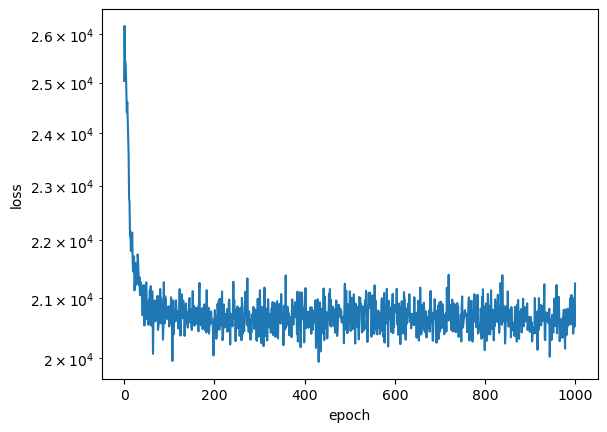

In [14]:
my_iterator = PsiIterator(device, batch_size=bs)
loss_train = my_iterator.Train(training_set)

plt.plot(loss_train)
plt.ylabel('loss')
plt.yscale('log')
plt.xlabel('epoch')
print("Average loss: ", torch.mean(loss_train[-100:]), ", STD: ", torch.std(loss_train[-100:]))

# save the list
torch.save(loss_train, os.path.join(model_dir,model_name+'.pt'))


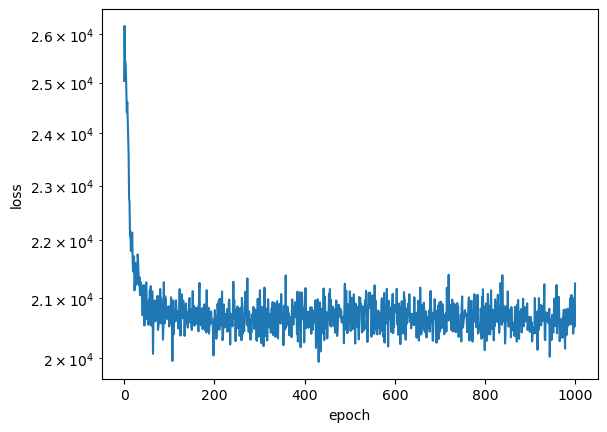

In [16]:
# import the learned model and loss train
my_net = PsiNet(mode='thermal').to(device_predict)
my_net.load_state_dict(torch.load(os.path.join(model_dir,model_name+'.pth')))
new_iterator = PsiIterator(device_predict, psi_net=my_net, grid=grid, batch_size=1)

my_loss = torch.load(os.path.join(model_dir,model_name+'.pt'))
plt.plot(my_loss)
plt.ylabel('loss')
plt.yscale('log')
plt.xlabel('epoch')
plt.savefig('results/smoother_loss.jpg', dpi=500, bbox_inches='tight')

0 6.21109784110908
1 2.158874280076516
2 1.0600615869086711
3 0.5767933914107389
4 0.35026792395689854
5 0.24533660504665455
6 0.19641332901764005
7 0.17082903715761044
8 0.15439484560976222
9 0.1417280118606287
10 0.13089215980958374
11 0.12117417809571293
12 0.1122865218943305
13 0.1040931556003652
14 0.09651489108409375
15 0.08949575467624567
16 0.08299054032824367
17 0.0769599647154465
18 0.07136865756234967
19 0.06618425180629842
20 0.06137691647263592
21 0.056919074237710435
22 0.05278519949868584
23 0.04895165422608803
24 0.04539654404721322
25 0.04209958741061521
26 0.039041994925462425
27 0.03620635762671575
28 0.033576543505581195
29 0.031137601813681266
30 0.028875674672566527
31 0.026777915507496496
32 0.024832413815048988
33 0.023028125778512126
34 0.021354810262333223
35 0.01980296974336532
36 0.01836379576820703
37 0.017029118559409848
38 0.01579136042649058
39 0.014643492669245646
40 0.01357899569003851
41 0.012591822058278936
42 0.011676362294126932
43 0.01082741315980

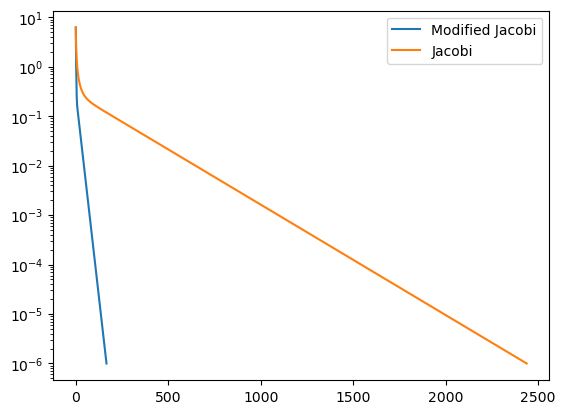

In [24]:
EPS = 1e-6
n_new = 0
u_test = torch.ones(size=(1, ku, n_elem+1, n_elem+1), requires_grad=False, dtype=torch.double).to(device_predict)
u_test = new_iterator.grid.jac.reset_boundary(u_test, d_test, d_idx_test)
residual = new_iterator.grid.net(h, u_test, f_test, t_test, t_idx_test, m_test)
res = torch.norm(residual[:, :, 1:-1, 1:-1]).item() # fix top, apply traction force at bottom boundary
res_arr_new = [res]
print(n_new, res)
while (abs(res) > EPS):
    u_test = new_iterator.PsiRelax(h, u_test, f_test, t_test, t_idx_test, d_test, d_idx_test, m_test, 1)
    residual = new_iterator.grid.net(h, u_test, f_test, t_test, t_idx_test, m_test)
    res = torch.norm(residual[:, :, 1:-1, 1:-1]).item()
    res_arr_new.append(res)
    n_new += 1
    print(n_new, res)

print("Solution converges after", n_new, "iterations ")
plt.plot(res_arr_new, label='Modified Jacobi')
plt.plot(res_arr, label='Jacobi')
plt.yscale('log')
plt.legend()
plt.show()